In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from model.utils import save_pickle, load_pickle
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
import torch
import importlib
from model.helper import matern_kernel, ker_approx


In [2]:
### template
data_path = 'data/NARPS'
mni_img = nib.load(f'{data_path}/group_analysis.ttest.1grp.equalRange.gain/MNI152_2009_template_SSW.nii.gz')
mni_data = mni_img.get_fdata()[:, :, :, 0, 0]  # Extract the 0-th volume
target_affine = mni_img.affine
x,y,z=(mni_data).nonzero()

### mask
mask_path = f'{data_path}/group_analysis.ttest.1grp.equalRange.gain/group_mask.inter.nii.gz'
mask_img = nib.Nifti1Image.from_filename(mask_path)
mask = nib.Nifti1Image.from_filename(mask_path).get_fdata()

In [3]:
### load data
narps = load_pickle('data/NARPS/data.pickle')
data = narps['data']
x,y,z = narps['coord']
S = narps['S']
N, V = data.shape
dtype = torch.float32

Pickle loaded from data/NARPS/data.pickle


In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern
### choose kernel function
ls = 0.1
# kernel = RBF(length_scale=ls)
kernel = Matern(length_scale=ls, nu=1.5)
L = 1200
L_eta = 50
n_chain = 3

In [5]:
import model.BSHE_Gibbs as BSHE_Gibbs
BSHE_Gibbs = importlib.reload(BSHE_Gibbs) 

In [6]:
model = BSHE_Gibbs.BSHE_voxel_GP( Y=data,X=None,
        grids=S, kernel=kernel,  L = L, L_eta = L_eta,
        burnin=5000,
        mcmc_sample=500,
        thin=2,
        dtype=dtype)
samples = model.run_multiple_chains(  
        n_chains=n_chain, 
        parallel=False,
    )

100%|██████████| 6000/6000 [01:06<00:00, 90.83it/s]


Chain 1 finished in 66.10 seconds


100%|██████████| 6000/6000 [01:06<00:00, 89.60it/s]


Chain 2 finished in 66.96 seconds


100%|██████████| 6000/6000 [01:05<00:00, 91.17it/s]

Chain 3 finished in 65.82 seconds


In [7]:
basis = model.B * (model.eig_val_sqrt.unsqueeze(0))

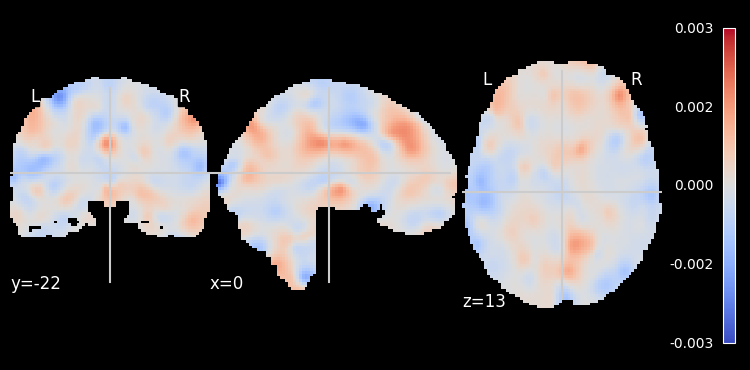

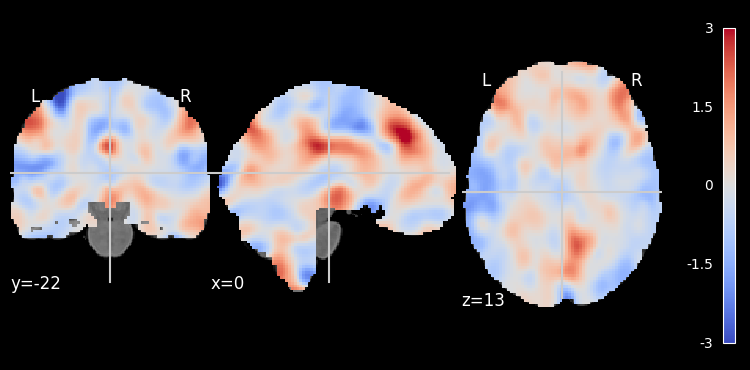

In [8]:
voxel_mcmc = samples['alpha'][:,:,:,None] + samples['theta_beta'] @ basis.t()
mean = voxel_mcmc.mean(dim=(0,1))
std = voxel_mcmc.std(dim=(0,1))
z_score = mean / std
post_map = np.zeros(mask_img.shape)
post_map[x, y, z] = mean
post_map_img = nib.Nifti1Image(post_map, mask_img.affine)
fig=plot_stat_map(post_map_img,
                bg_img=nib.Nifti1Image(mask, mask_img.affine),
                colorbar=True,
                threshold=0,
                cbar_tick_format="%.3f",
                vmax=0.003, vmin=-0.003,
                cmap='coolwarm',
                cut_coords=[0, -22, 13])
#fig.savefig('plots/voxel_m21_mean.png', dpi=300)

post_map = np.zeros(mask_img.shape)
post_map[x, y, z] =  mean / std
post_map_img = nib.Nifti1Image(post_map, mask_img.affine)
fig=plot_stat_map(post_map_img,
                bg_img=nib.Nifti1Image(mni_data, mni_img.affine),
                colorbar=True,
                threshold=0,
                vmax=3, vmin=-3,
                cmap='coolwarm',
                cut_coords=[0, -22, 13])
#fig.savefig('plots/voxel_m21_zscore.png', dpi=300)
